Polynomial Regression - you can use your data to build a linear or polynomial regression line.  Use this line to predict future values.

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pandas_profiling import ProfileReport
import math as ma

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

import operator

get_ipython().run_line_magic('matplotlib', 'inline')

In [97]:
def years_prior(df: pd.DataFrame, years = 0.0, inplace = False) -> pd.DataFrame:

    days = ma.floor(360 * years)
    index_to_drop = range(0, len(df.index) - days)

    if(index_to_drop[-1] > df.index[-1]):

        return df.drop(index = df.index, inplace = inplace)
        
    else:

        return df.drop(index = index_to_drop, inplace = inplace)


def weeks_prior(df: pd.DataFrame, weeks = 1) -> pd.DataFrame:

    days = ma.floor(7 * weeks)
    index_to_drop = range(0, len(df.index) - days)

    if(index_to_drop[-1] > df.index[-1]):

        return df.drop(index = df.index)
        
    else:

        return df.drop(index = index_to_drop)


def time_prior(df: pd.DataFrame, duration: float, unit: str, time_frame = 0.0) -> pd.DataFrame:

    interval_factor = { 'year': 360, 'quater': 90, 'month': 30, 'week': 7, 'day': 1 }

    if unit not in interval_factor:

        raise Exception('time_unit may only be "year", "quater", "month", or "day"')


    epoch = len(df.index) - ma.floor(interval_factor[unit] * duration)

    if(epoch < 0):

        raise Exception(f'duration {duration} {unit} is greater than the dataset of length {len(df.index)}')


    if time_frame == 0.0:

        return df[(df.index >= epoch)]

    else:
        
        end = epoch + ma.floor(time_frame * interval_factor[unit])

        return df[(df.index >= epoch) & (df.index < end)]


def polynomial_regression(x: np.ndarray, y: np.ndarray , degree: int) -> LinearRegression:

    '''
        Takes in two list: x and y, and returns a polynomial regression model based on the degree argument
    '''
    
    x_poly = PolynomialFeatures(degree = degree).fit_transform(x)

    return LinearRegression().fit(x_poly, y)

    

In [64]:
df_cardano  = pd.read_csv('../data/Cardano.csv',    parse_dates = ['Date']).drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])
df_ethereum = pd.read_csv('../data/Ethereum.csv',   parse_dates = ['Date']).drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])
df_solana   = pd.read_csv('../data/Solana.csv',     parse_dates = ['Date']).drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])
df_dogecoin = pd.read_csv('../data/Dogecoin.csv',   parse_dates = ['Date']).drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])

#df = pd.merge(pd.merge(df_cardano, df_ethereum, on = 'Date', how = "left", suffixes = ['_cardano', '_ether']), pd.merge(df_solana, df_dogecoin, on = 'Date', how = "left", suffixes = ['_solana', '_dogecoin']), on = 'Date', how = "left")


# plt.plot(df_cardano_week['Date'], df_cardano_week['Closing Price (USD)'], label = 'None', color = 'red')
# plt.plot(df.Date, df['Closing Price (USD)'], label = 'None', color = 'blue')
# plt.plot(df_solana.Date, df_solana['Closing Price (USD)'], label = 'None', color = 'green')
# plt.plot(df_dogecoin.Date, df_dogecoin['Closing Price (USD)'], label = 'None', color = 'pink')

# plt.show()

# plt.plot(df_cardano_week['Date'], model.predict(df_cardano_week[['Date']]), color = 'm')

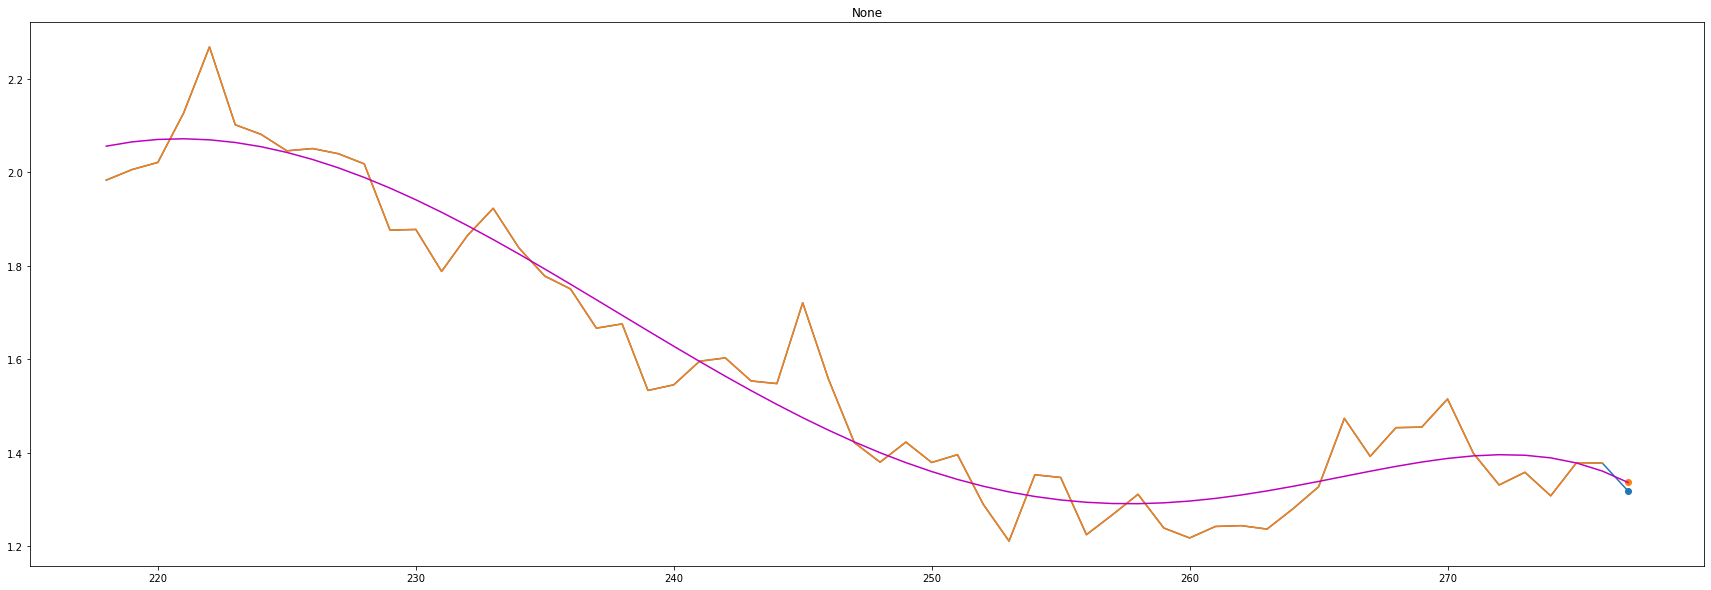

In [147]:
plt.figure(figsize = (30,10))
plt.grid(False)
plt.title('None')

start = 60
time_frame = 59

df_cardano_full = time_prior(df_cardano, start, 'day', time_frame + 1)
df_cardano_train = time_prior(df_cardano, start, 'day', time_frame)
df_cardano_test = time_prior(df_cardano, start - time_frame, 'day', 1)

x_full = df_cardano_full.index.to_numpy() 
y_full = df_cardano_full['Closing Price (USD)'].to_numpy()
x_train = df_cardano_train.index.to_numpy()
x_test  = df_cardano_test.index.to_numpy()
y_train = df_cardano_train['Closing Price (USD)'].to_numpy()
y_test  = df_cardano_test['Closing Price (USD)'].to_numpy()

polynomial_features = PolynomialFeatures(degree = 6)
x_poly_train = polynomial_features.fit_transform(x_train[:, None])

model = LinearRegression()
model.fit(x_poly_train, y_train)

y_pred_test = model.predict(polynomial_features.fit_transform(x_test[:, None]))
y_pred_full = model.predict(polynomial_features.fit_transform(x_full[:, None]))

plt.scatter(x_test, y_test, label = 'actual')
plt.scatter(x_test, y_pred_test, label = 'predicted')

plt.plot(df_cardano_full.index, df_cardano_full['Closing Price (USD)'])
plt.plot(df_cardano_train.index, df_cardano_train['Closing Price (USD)'])

sorted_zip = sorted(zip(x_full, y_pred_full), key = operator.itemgetter(0))
x_full, y_pred_full = zip(*sorted_zip)

plt.plot(x_full, y_pred_full, color='m')

plt.show()